In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import csv
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandasql as ps

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [4]:
sns.set_style = 'seaborn-whitegrid'

sns.set(rc={"font.style":"normal",
            "axes.facecolor":"white",
            'grid.color': '.8',
            'grid.linestyle': '-',
            "figure.facecolor":"white",
            "figure.titlesize":20,
            "text.color":"black",
            "xtick.color":"black",
            "ytick.color":"black",
            "axes.labelcolor":"black",
            "axes.grid":True,
            'axes.labelsize':10,
            'xtick.labelsize':10,
            'font.size':10,
            'ytick.labelsize':10})

# 1. Discover Data

In [5]:
df = pd.read_csv('../data/womens_clothing_ecommerce_reviews.csv',
                 index_col=0)

In [6]:
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,847,33,"Cute, crisp shirt",If this product was in petite i would get the...,4,1,2,General,Tops,Blouses
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,I love love love this jumpsuit. it's fun fl...,5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [7]:
df.shape

(23486, 10)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23486 entries, 0 to 23485
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Clothing ID              23486 non-null  int64 
 1   Age                      23486 non-null  int64 
 2   Title                    19676 non-null  object
 3   Review Text              22641 non-null  object
 4   Rating                   23486 non-null  int64 
 5   Recommended IND          23486 non-null  int64 
 6   Positive Feedback Count  23486 non-null  int64 
 7   Division Name            23472 non-null  object
 8   Department Name          23472 non-null  object
 9   Class Name               23472 non-null  object
dtypes: int64(5), object(5)
memory usage: 2.0+ MB


# 2. Transform data

To simplify the task, we transform the data into a comma-separated value (CSV) file that contains only a `review_body`, `product_category`, and `sentiment` derived from the original data.

In [9]:
df_transformed = df.rename(columns={'Review Text': 'review_body',
                                    'Rating': 'star_rating',
                                    'Class Name': 'product_category'})
df_transformed.drop(columns=['Clothing ID', 'Age', 'Title', 'Recommended IND', 'Positive Feedback Count', 'Division Name', 'Department Name'],
                    inplace=True)

df_transformed.dropna(inplace=True)

df_transformed.shape

(22628, 3)

In [10]:
def to_sentiment(star_rating):
    if star_rating in {1, 2}: # negative
        return -1 
    if star_rating == 3:      # neutral
        return 0
    if star_rating in {4, 5}: # positive
        return 1

In [11]:
# transform star_rating into the sentiment
df_transformed['sentiment'] = df_transformed['star_rating'].apply(lambda star_rating: 
    to_sentiment(star_rating=star_rating) 
)

# drop the star rating column
df_transformed.drop(columns=['star_rating'],
                    inplace=True)

# remove reviews for product_categories with < 10 reviews
df_transformed = df_transformed.groupby('product_category').filter(lambda reviews : len(reviews) > 10)[['sentiment', 'review_body', 'product_category']]

df_transformed.shape

(22626, 3)

# 3. save transformed data

In [12]:
df_transformed.to_csv('../data/womens_clothing_ecommerce_reviews_transformed.csv', 
                      index=False)

# 4. Query the data

### 4.1. How many reviews per sentiment?

In [16]:
statement_count_by_sentiment = """
SELECT sentiment, COUNT(sentiment) AS count_sentiment
FROM df_transformed
GROUP BY sentiment
ORDER BY sentiment
"""

In [21]:
df_count_by_sentiment = ps.sqldf(statement_count_by_sentiment, locals())
df_count_by_sentiment

,sentiment,count_sentiment
0,-1,2370
1,0,2823
2,1,17433


<AxesSubplot:xlabel='sentiment'>

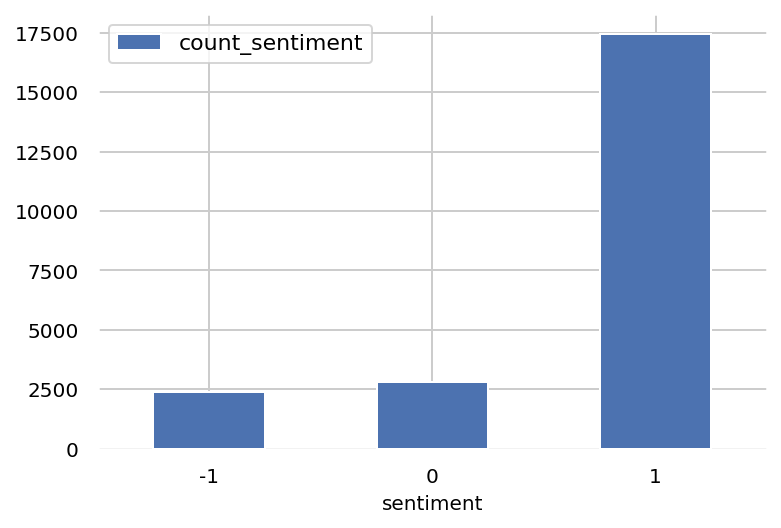

In [22]:
df_count_by_sentiment.plot(kind='bar', x='sentiment', y='count_sentiment', rot=0)

In [23]:
statement_count_by_category = """
SELECT product_category, COUNT(product_category) AS count_product_category
FROM df_transformed
GROUP BY product_category
ORDER BY count_product_category DESC
"""

In [24]:
df_count_by_category = ps.sqldf(statement_count_by_category, locals())
df_count_by_category

,product_category,count_product_category
0,Dresses,6145
1,Knits,4626
2,Blouses,2983
3,Sweaters,1380
4,Pants,1350
5,Jeans,1104
6,Fine gauge,1059
7,Skirts,903
8,Jackets,683
9,Lounge,669


### 4.2. Which product categories are highest rated by average sentiment?

In [25]:
statement_avg_by_category = """
SELECT product_category, AVG(sentiment) AS avg_sentiment
FROM df_transformed
GROUP BY product_category 
ORDER BY avg_sentiment DESC
"""

In [27]:
df_avg_by_category = ps.sqldf(statement_avg_by_category, locals())
df_avg_by_category

,product_category,avg_sentiment
0,Layering,0.780303
1,Jeans,0.746377
2,Lounge,0.745889
3,Sleep,0.710280
4,Shorts,0.707237
5,Pants,0.705185
6,Intimates,0.700680
7,Jackets,0.699854
8,Skirts,0.696567
9,Legwear,0.696203


In [28]:
def show_values_barplot(axs, space):
    def _show_on_plot(ax):
        for p in ax.patches:
            _x = p.get_x() + p.get_width() + float(space)
            _y = p.get_y() + p.get_height()
            value = round(float(p.get_width()),2)
            ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_plot(ax)
    else:
        _show_on_plot(axs)

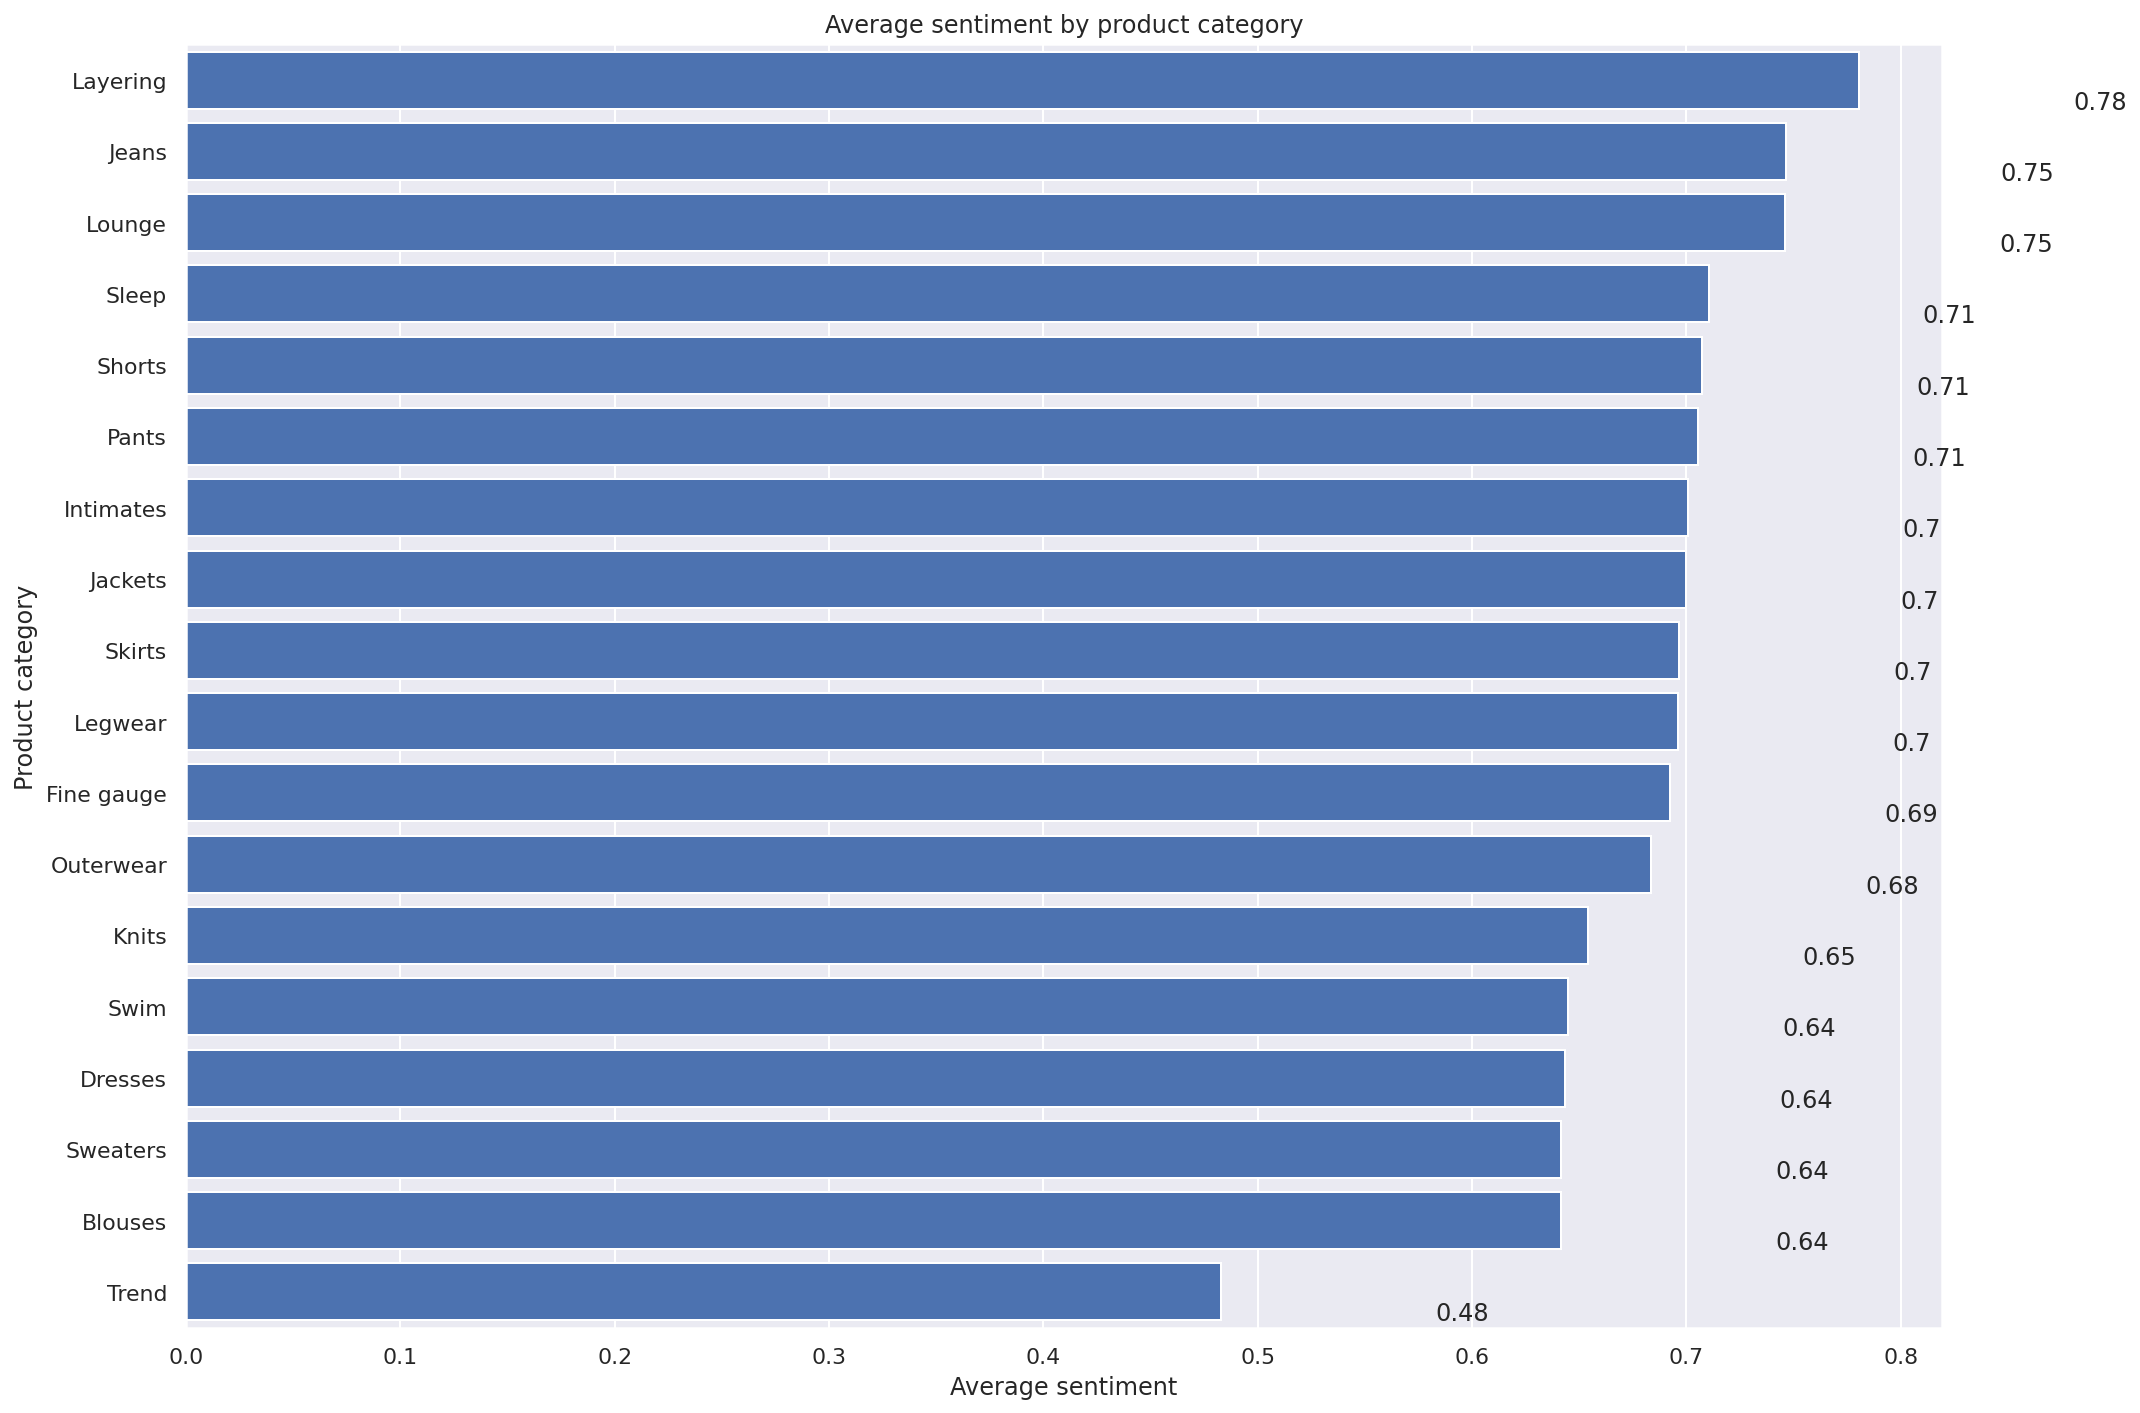

In [62]:
# Create plot
barplot = sns.barplot(
    data = df_avg_by_category, 
    y='product_category',
    x='avg_sentiment', 
    color="b", 
    saturation=1
)
sns.set(rc={'figure.figsize':(15.0, 10.0)})
plt.title('Average sentiment by product category')
show_values_barplot(barplot, 0.1)
plt.xlabel("Average sentiment")
plt.ylabel("Product category")
plt.tight_layout()
plt.savefig('../images/avg_sentiment_per_category.png', dpi=300)
# Show graphic
plt.show(barplot)

### 4.3. Which product categories have the most reviews?

In [32]:
statement_count_by_category_desc = """
SELECT product_category, COUNT(*) AS count_reviews 
FROM df_transformed
GROUP BY product_category 
ORDER BY count_reviews DESC
"""

In [33]:
df_count_by_category_desc = ps.sqldf(statement_count_by_category_desc, locals())

In [34]:
max_sentiment = df_count_by_category_desc['count_reviews'].max()
print('Highest number of reviews (in a single category): {}'.format(max_sentiment))

Highest number of reviews (in a single category): 6145


In [35]:
df_count_by_category_desc

,product_category,count_reviews
0,Dresses,6145
1,Knits,4626
2,Blouses,2983
3,Sweaters,1380
4,Pants,1350
5,Jeans,1104
6,Fine gauge,1059
7,Skirts,903
8,Jackets,683
9,Lounge,669


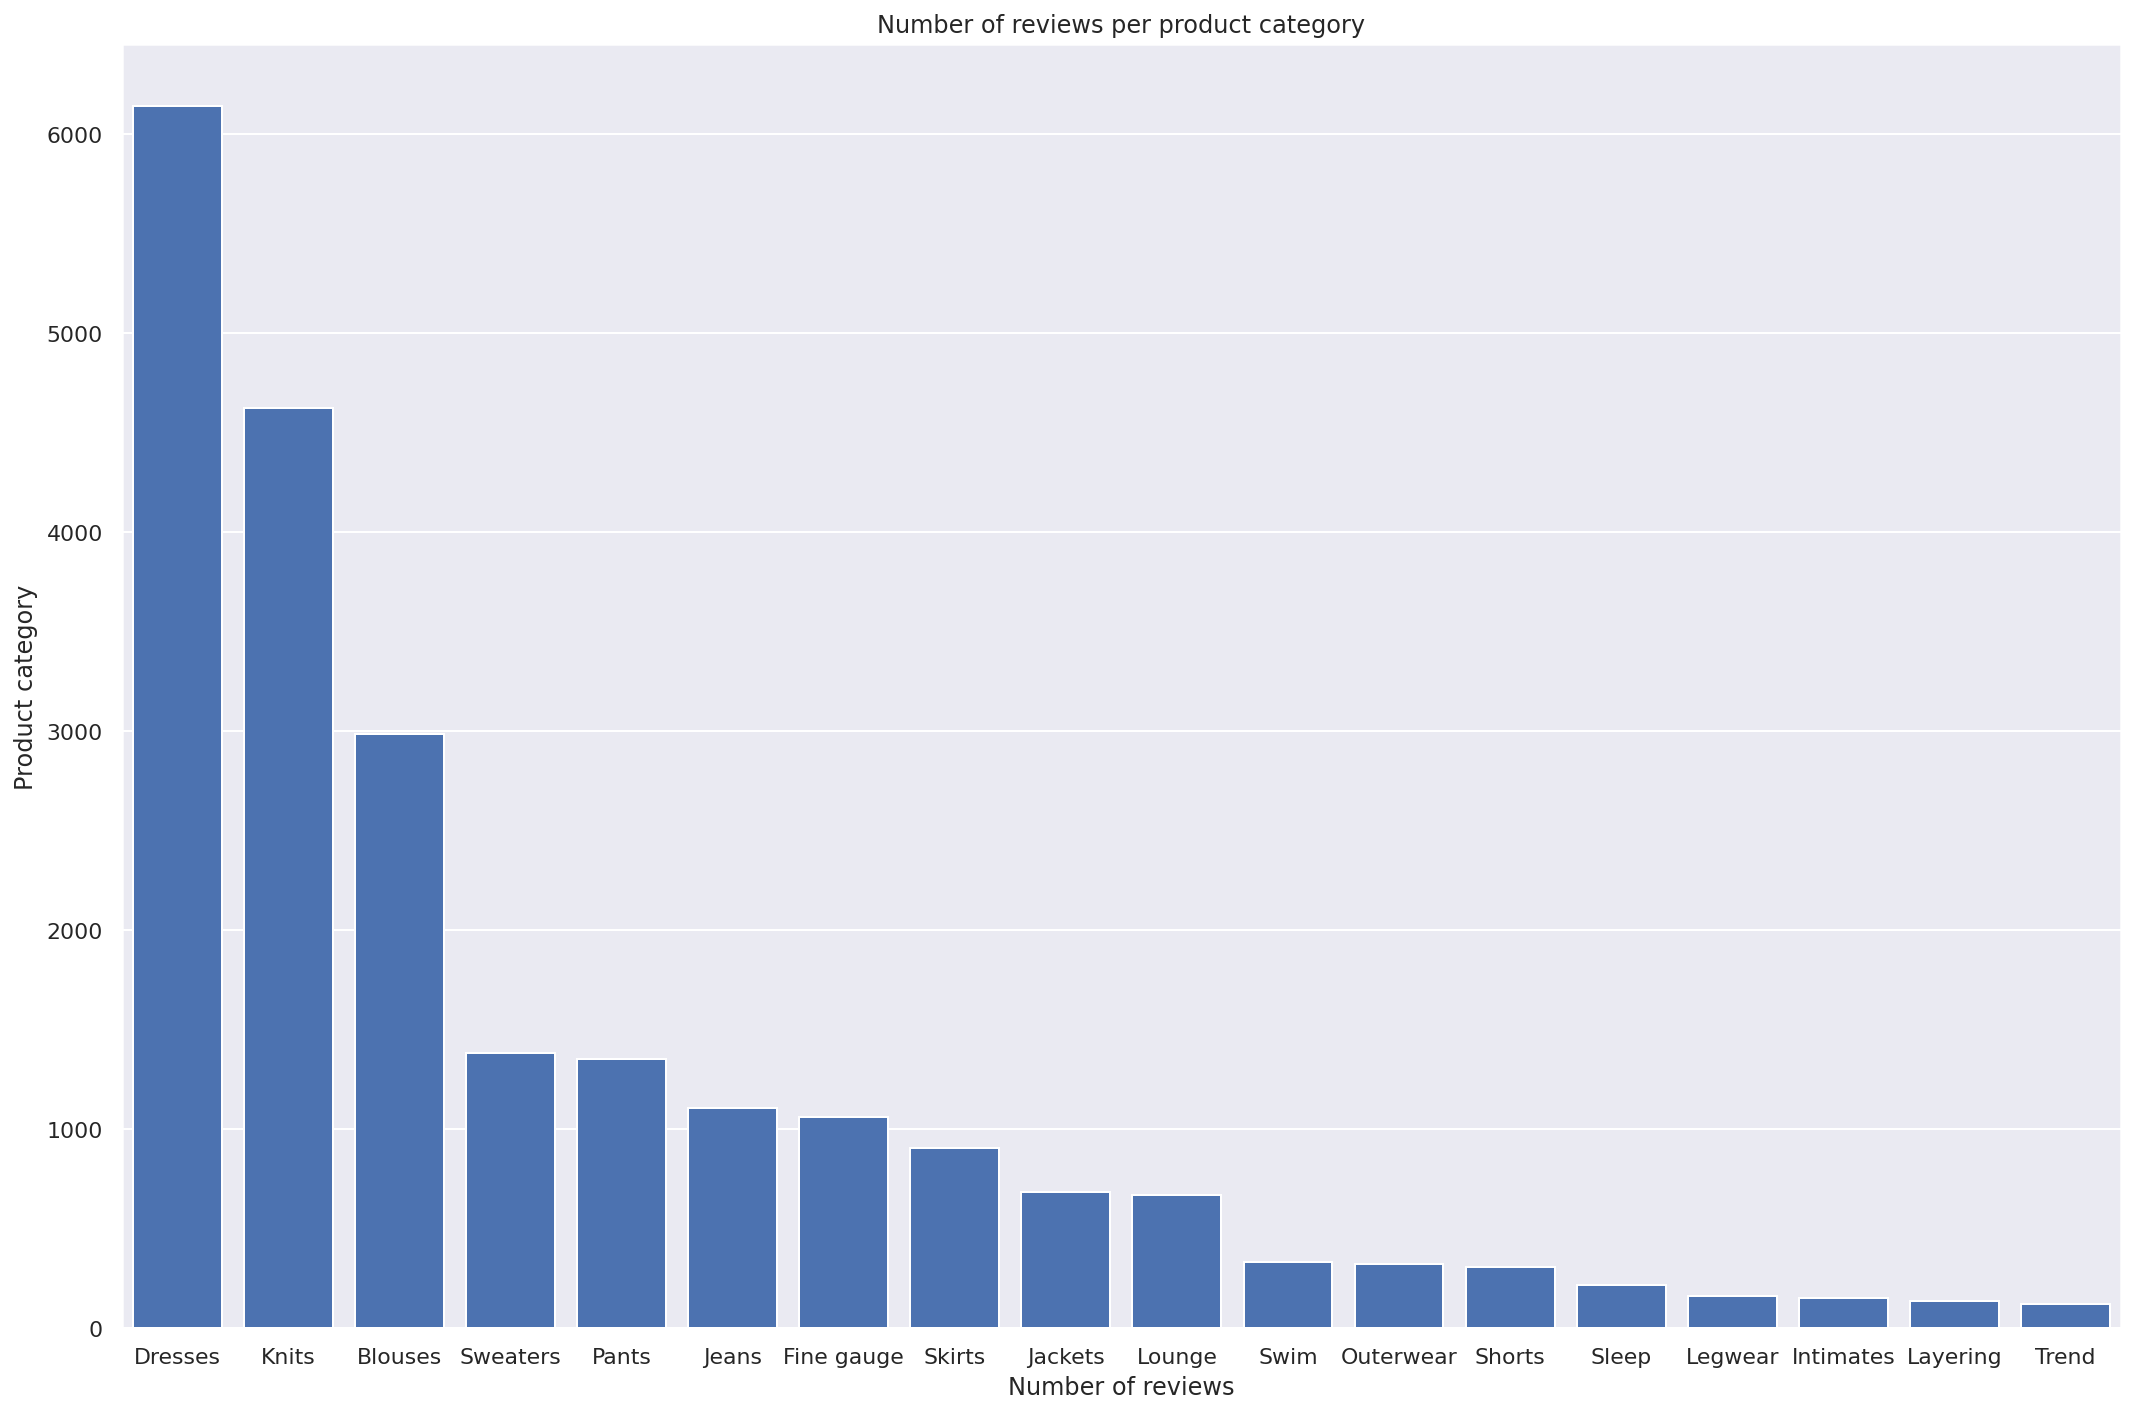

In [63]:
# Create seaborn barplot
barplot = sns.barplot(
    data=df_count_by_category_desc,
    y="count_reviews", 
    x="product_category", 
    color="b",
    saturation=1
)
sns.set(rc={'figure.figsize':(15.0, 10.0)})
plt.title("Number of reviews per product category")
plt.xlabel("Number of reviews")
plt.ylabel("Product category")
plt.tight_layout()
plt.savefig('../images/num_reviews_per_category.png', dpi=300)
plt.show(barplot)

### 4.4. What is the breakdown of sentiments per product category?

In [38]:
statement_count_by_category_and_sentiment = """
SELECT product_category,
         sentiment,
         COUNT(*) AS count_reviews
FROM df_transformed
GROUP BY  product_category, sentiment
ORDER BY  product_category ASC, sentiment DESC, count_reviews
"""

In [39]:
df_count_by_category_and_sentiment = ps.sqldf(statement_count_by_category_and_sentiment, locals())

In [40]:
# Create grouped dataframes by category and by sentiment
grouped_category = df_count_by_category_and_sentiment.groupby('product_category')
grouped_star = df_count_by_category_and_sentiment.groupby('sentiment')

# Create sum of sentiments per star sentiment
df_sum = df_count_by_category_and_sentiment.groupby(['sentiment']).sum()

# Calculate total number of sentiments
total = df_sum['count_reviews'].sum()
print('Total number of reviews: {}'.format(total))

Total number of reviews: 22626


In [41]:
distribution = {}
count_reviews_per_star = []
i=0

for category, sentiments in grouped_category:
    count_reviews_per_star = []
    for star in sentiments['sentiment']:
        count_reviews_per_star.append(sentiments.at[i, 'count_reviews'])
        i=i+1;
    distribution[category] = count_reviews_per_star

In [42]:
distribution

{'Blouses': [2256, 384, 343],
 'Dresses': [4634, 830, 681],
 'Fine gauge': [837, 118, 104],
 'Intimates': [117, 16, 14],
 'Jackets': [550, 61, 72],
 'Jeans': [909, 110, 85],
 'Knits': [3523, 605, 498],
 'Layering': [113, 9, 10],
 'Legwear': [126, 16, 16],
 'Lounge': [545, 78, 46],
 'Outerwear': [254, 29, 36],
 'Pants': [1074, 154, 122],
 'Shorts': [240, 39, 25],
 'Skirts': [714, 104, 85],
 'Sleep': [175, 16, 23],
 'Sweaters': [1036, 193, 151],
 'Swim': [252, 42, 38],
 'Trend': [78, 19, 21]}

In [43]:
df_distribution_pct = pd.DataFrame(distribution).transpose().apply(
    lambda num_sentiments: num_sentiments/sum(num_sentiments)*100, axis=1
)
df_distribution_pct.columns=['1', '0', '-1']
df_distribution_pct

,1,0,-1
Blouses,75.628562,12.872947,11.498491
Dresses,75.410903,13.506916,11.082181
Fine gauge,79.036827,11.142587,9.820585
Intimates,79.591837,10.884354,9.523810
Jackets,80.527086,8.931186,10.541728
Jeans,82.336957,9.963768,7.699275
Knits,76.156507,13.078253,10.765240
Layering,85.606061,6.818182,7.575758
Legwear,79.746835,10.126582,10.126582
Lounge,81.464873,11.659193,6.875934


<Figure size 720x360 with 0 Axes>

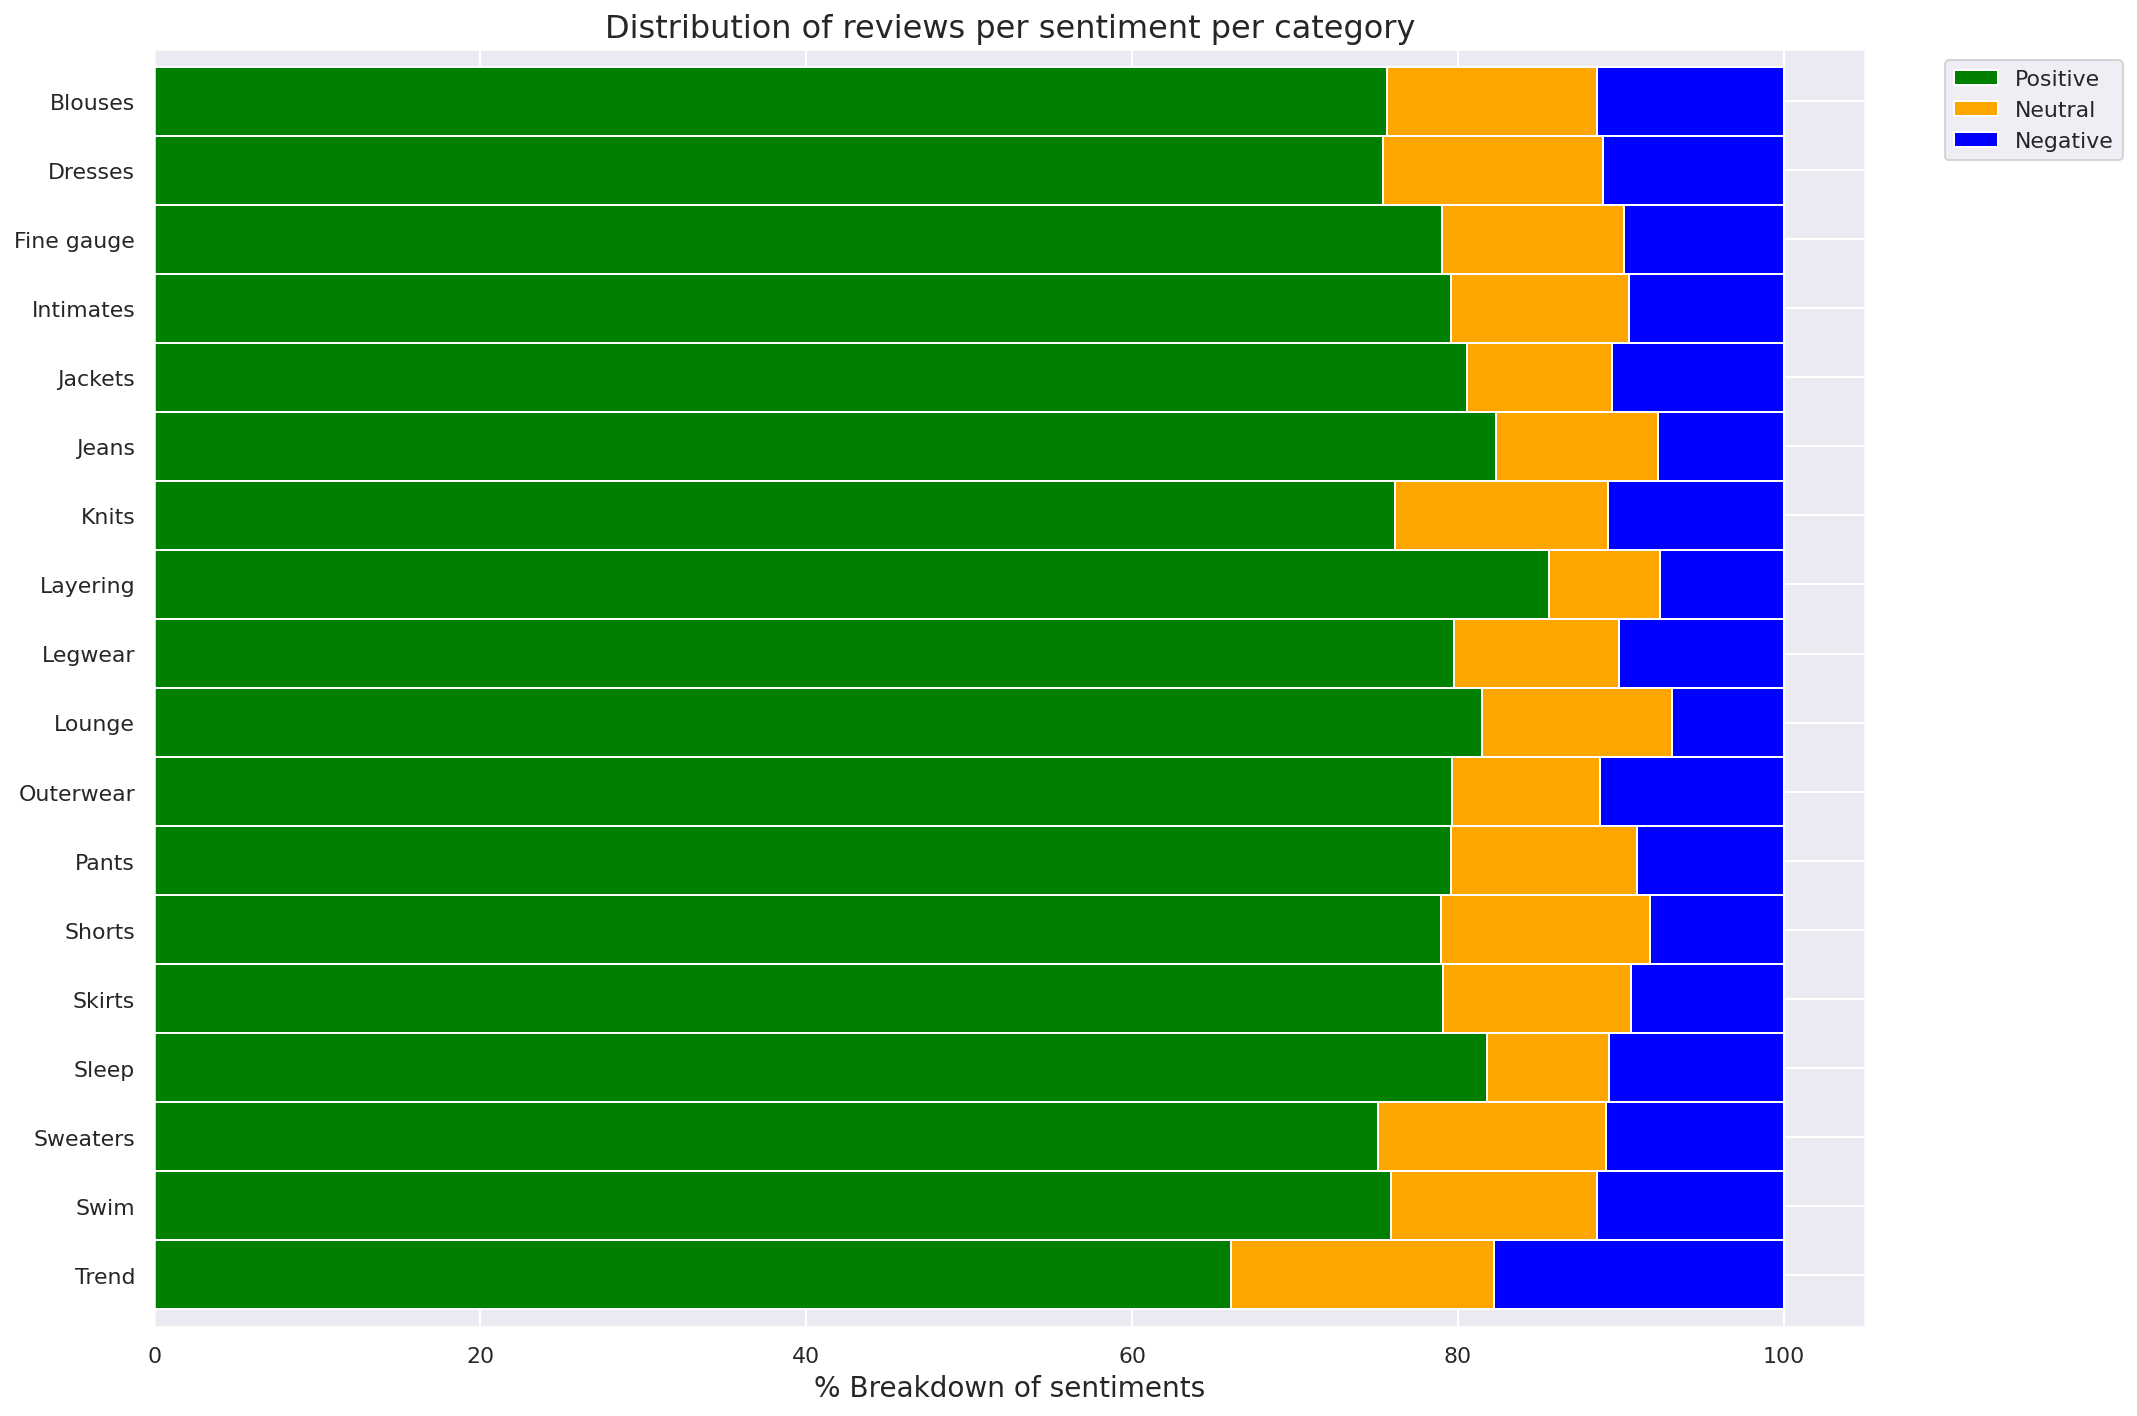

In [64]:
categories = df_distribution_pct.index
plt.figure(figsize=(10,5))
df_distribution_pct.plot(kind="barh", 
                         stacked=True, 
                         edgecolor='white',
                         width=1.0,
                         color=['green', 
                                'orange', 
                                'blue'])
plt.title("Distribution of reviews per sentiment per category", 
          fontsize='16')
plt.legend(bbox_to_anchor=(1.04,1), 
           loc="upper left",
           labels=['Positive', 
                   'Neutral', 
                   'Negative'])
plt.xlabel("% Breakdown of sentiments", fontsize='14')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('../images/distribution_sentiment_per_category.png', dpi=300)
plt.show()

### 4.5. Analyze the distribution of review word counts

In [47]:
df_transformed.head()

,sentiment,review_body,product_category
0,1,If this product was in petite i would get the...,Blouses
1,1,Love this dress! it's sooo pretty. i happene...,Dresses
2,0,I had such high hopes for this dress and reall...,Dresses
3,1,I love love love this jumpsuit. it's fun fl...,Pants
4,1,This shirt is very flattering to all due to th...,Blouses


In [57]:
statement_num_words = """
    SELECT length(review_body) - length(replace(review_body, ' ', '')) + 1 as num_words
    FROM df_transformed
"""


In [58]:
df_num_words = ps.sqldf(statement_num_words, locals())

In [59]:
df_num_words

,num_words
0,70
1,68
2,102
3,27
4,36
...,...
22621,28
22622,40
22623,44
22624,90


In [60]:
summary = df_num_words["num_words"].describe(percentiles=[0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1.00])
summary

count    22626.000000
mean        62.709847
std         29.993735
min          2.000000
10%         22.000000
20%         33.000000
30%         42.000000
40%         51.000000
50%         61.000000
60%         72.000000
70%         86.000000
80%         97.000000
90%        103.000000
100%       122.000000
max        122.000000
Name: num_words, dtype: float64

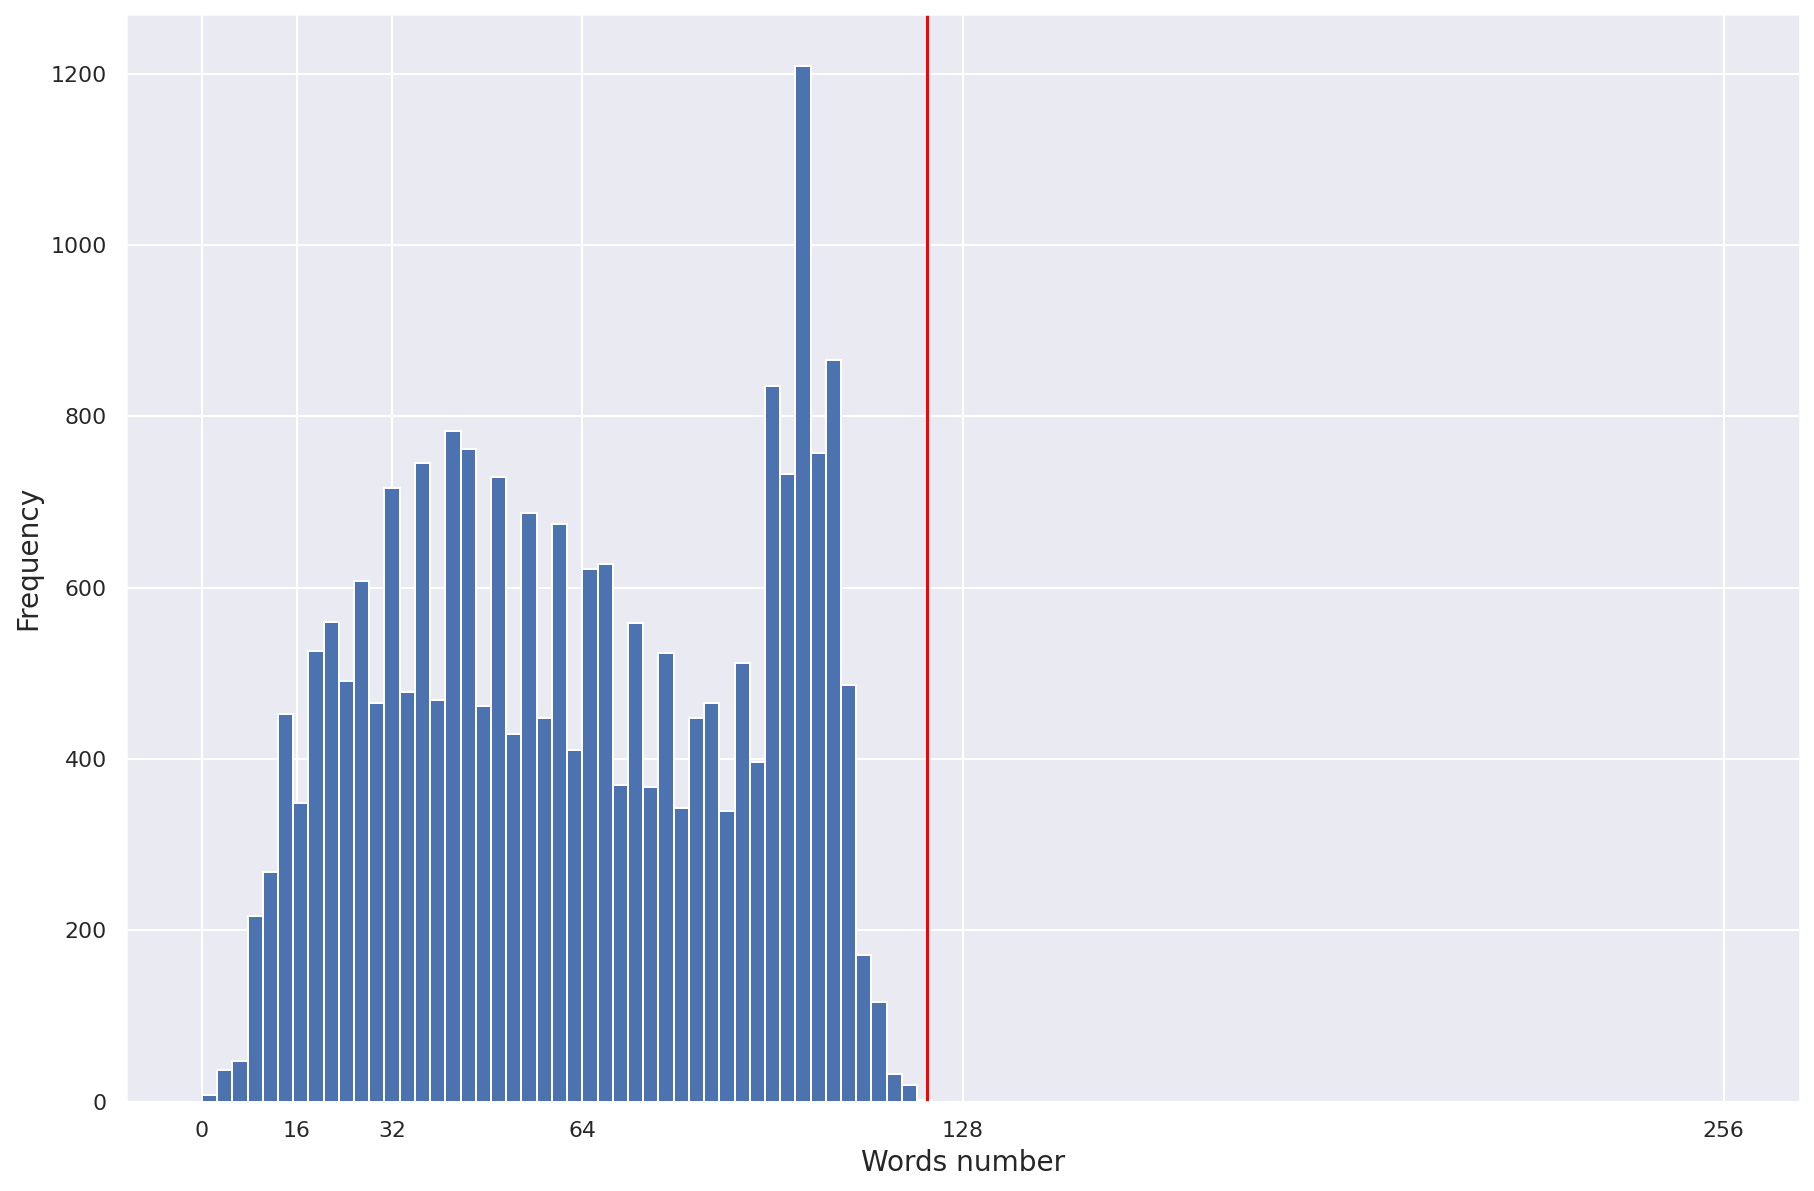

In [65]:
df_num_words["num_words"].plot.hist(xticks=[0, 16, 32, 64, 128, 256], bins=100, range=[0, 256]).axvline(
    x=summary["100%"], c="red"
)

plt.xlabel("Words number", fontsize='14')
plt.ylabel("Frequency", fontsize='14')
plt.savefig('../images/distribution_num_words_per_review.png', dpi=300)
plt.show()